In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
file="/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/dots/" #"C:/Users/dexte/github/RoboSkin/Code/Models/TacTip reader/dots/"

/its/home/drs25/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Load dataset

(990, 133, 2) (990, 480, 640)


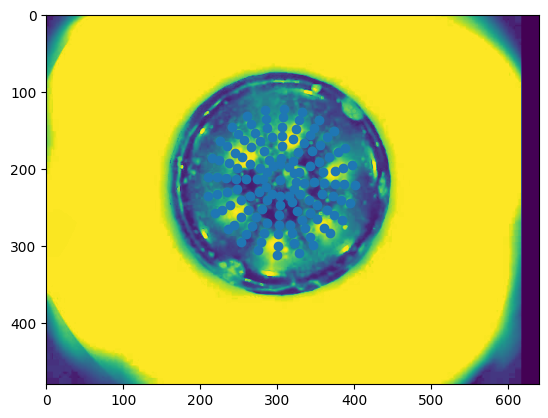

(990, 480, 640)


In [2]:
#load dataset
y=np.load(file+"augmentedNewTacTip.npy")
X=np.load(file+"augmentedNewTacTipimages.npy").astype(np.uint8)
X_=np.zeros((len(X),X.shape[1],X.shape[2],)).astype(np.uint8)
for i in range(len(X)):
    X_[i]= cv2.cvtColor(X[i],cv2.COLOR_BGR2GRAY)
    """X_[i] = cv2.adaptiveThreshold(
            X_[i], 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 1
        )
    kernel = np.ones((2, 2), np.uint8)
    X_[i] = cv2.erode(X_[i], kernel, iterations=1)"""
X=X_.copy()
print(y.shape,X.shape)
plt.imshow(X[0])
plt.scatter(y[0,:,0],y[0,:,1])
plt.show()
print(X_.shape)

-270 -260


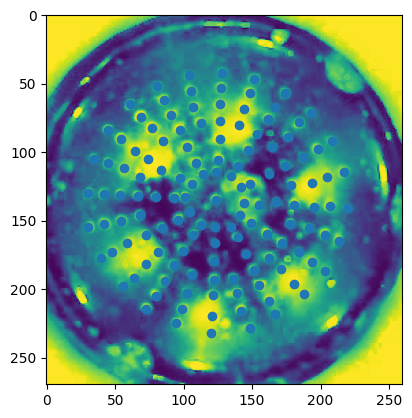

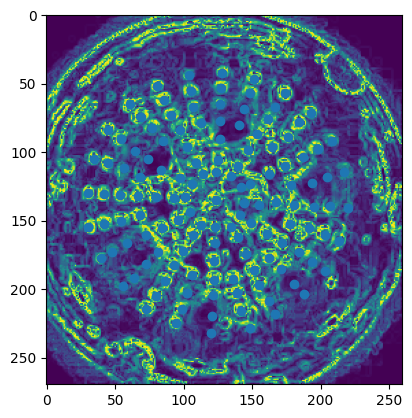

In [3]:
#crop dataset
print(80-350,180-440)
X_=X[:,80:350,180:440].copy()
y_=y.copy()
y_[:,:,0]-=180
y_[:,:,1]-=80
plt.imshow(X_[0])
plt.scatter(y_[0,:,0],y_[0,:,1])
plt.show()
#sobel filter
def applySobel(X):
    for i in range(len(X)): #crop all images individually
        image=X[i]
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        X[i]=sobel_combined
    return X_
X_=applySobel(X_)
plt.imshow(X_[0])
plt.scatter(y_[0,:,0],y_[0,:,1])
plt.show()
del X

In [4]:
import numpy as np
import cv2
from skimage.exposure import match_histograms
from tqdm import tqdm

# --- CONFIGURATION ---
APPLY_BRIGHTNESS_CONTRAST = True
APPLY_BLUR = True
APPLY_NOISE = True

BRIGHTNESS_ADJ = -40  # [-100, 100]
CONTRAST_ADJ = -30    # [-100, 100]
NOISE_STD = 5         # standard deviation for noise

# --- FUNCTIONS ---

def adjust_brightness_contrast(image, brightness=0, contrast=0):
    """Adjust brightness and contrast of a single image using OpenCV."""
    return cv2.convertScaleAbs(image, alpha=1 + contrast / 100.0, beta=brightness)

def preprocess_image_numpy(bright_img, dim_reference_img):
    """Preprocess a single bright image using a dim reference."""
    # Histogram match
    matched = match_histograms(bright_img, dim_reference_img, channel_axis=None)

    # Brightness/contrast adjustment
    if APPLY_BRIGHTNESS_CONTRAST:
        matched = adjust_brightness_contrast(matched, BRIGHTNESS_ADJ, CONTRAST_ADJ)

    # Blur
    if APPLY_BLUR:
        matched = cv2.GaussianBlur(matched, (3, 3), 0)

    # Add noise
    if APPLY_NOISE:
        noise = np.random.normal(0, NOISE_STD, matched.shape)
        matched = np.clip(matched + noise, 0, 255).astype(np.uint8)

    # Normalize
    matched = matched.astype(np.float32)
    matched = (matched - np.mean(matched)) / (np.std(matched) + 1e-6)

    return matched

def preprocess_dataset_numpy(bright_dataset, dim_dataset, save_path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/dots/"):
    """
    Preprocess a dataset of bright images (NumPy array) to match dim image style.

    bright_dataset: np.ndarray of shape (N, H, W)
    dim_dataset: np.ndarray of shape (M, H, W)
    save_path: optional, folder to save npy files
    """
    preprocessed = []

    # Use the mean of dim dataset as reference
    dim_reference = np.mean(dim_dataset, axis=0).astype(np.uint8)

    for i, bright_img in enumerate(tqdm(bright_dataset)):
        processed_img = preprocess_image_numpy(bright_img.astype(np.uint8), dim_reference)
        preprocessed.append(processed_img)

        if save_path:
            np.save(f"{save_path}/preprocessed_{i}.npy", processed_img)

    return np.stack(preprocessed)

# --- EXAMPLE USAGE ---
# Assume you have:
# bright_dataset: (N, H, W)
# dim_dataset: (M, H, W)
bright_dataset=X_
Xk=np.load("/its/home/drs25/Documents/data/Tactile Dataset/datasets/X_data_15.npz")
for array in Xk:
    pass
dim_dataset=applySobel(Xk[array])
# Example:
preprocessed_bright = preprocess_dataset_numpy(bright_dataset, dim_dataset)

100%|██████████| 990/990 [00:03<00:00, 275.58it/s]


In [39]:
cv2.imwrite("/its/home/drs25/Documents/GitHub/Robot_foot/assets/example_image.png",X_[0])

True

# Modelling

In [10]:
import joblib
from sklearn.decomposition import PCA
pca = PCA(n_components=150)  # or however many dimensions you want
X_flat=preprocessed_bright.reshape((preprocessed_bright.shape[0],-1))
x_reduced = pca.fit_transform(X_flat)
joblib.dump(pca, '/its/home/drs25/Documents/GitHub/Robot_foot/Robot_foot/models/pca_model.joblib')

['/its/home/drs25/Documents/GitHub/Robot_foot/Robot_foot/models/pca_model.joblib']

In [44]:
print(X_flat.shape,X_[0].shape,270*260)

(990, 70200) (270, 260) 70200


In [11]:

"""X_=X[:,80:350,180:440]
y_=y.copy()
y_[:,:,0]-=180
y_[:,:,1]-=80"""
average_error=[]
train_error=[]
for i in range(20):
    X_flat=X_.reshape((X_.shape[0],-1))
    y_flat=y_.reshape((y_.shape[0],-1))
    print(X_flat.shape,y_flat.shape)
    X_train, X_test, y_train, y_test = train_test_split(x_reduced, y_flat, test_size=0.2, random_state=np.random.randint(0,70))

    clf = Ridge(alpha=1.0)
    clf.fit(X_train, y_train)

    coords=clf.predict(X_test)
    print(coords.shape)
    distances = np.linalg.norm(coords - y_test, axis=0)
    print(distances.shape)
    # Find the maximum, minimum, and average distances
    max_distance = np.max(distances)
    min_distance = np.min(distances)
    average_distance = np.mean(distances)
    #print(f"Maximum Euclidean distance: {max_distance}")
    #print(f"Minimum Euclidean distance: {min_distance}")
    #print(f"Average Euclidean distance: {average_distance}")
    #print(f"Test Average error: {average_distance/481.3 *100}%")
    average_error.append(average_distance/481.3 *100)
    coords=clf.predict(X_train)
    distances = np.linalg.norm(coords - y_train, axis=0)
    average_distance = np.mean(distances)
    train_error.append(average_distance/481.3 *100)
error=np.average(np.array(average_error))
print("\n\n\nAverage test",100-error,"%")
error=np.average(np.array(train_error))
print("Average train",100-error,"%")
print("STD error",np.std(np.array(average_error)),"%")

(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)
(990, 70200) (990, 266)
(198, 266)
(266,)



Average test 86.90434319896445 %
Average train 79.15515958448641 %
STD error 0.5585377096277218 %


In [12]:
joblib.dump(clf, '/its/home/drs25/Documents/GitHub/Robot_foot/Robot_foot/models/regression_model_ridge.joblib')

['/its/home/drs25/Documents/GitHub/Robot_foot/Robot_foot/models/regression_model_ridge.joblib']

In [37]:

"""X_=X[:,80:350,180:440]
y_=y.copy()
y_[:,:,0]-=180
y_[:,:,1]-=80"""
average_error=[]
train_error=[]
for i in range(20):
    X_flat=X_.reshape((X_.shape[0],-1))
    y_flat=y_.reshape((y_.shape[0],-1))
    X_train, X_test, y_train, y_test = train_test_split(x_reduced, y_flat, test_size=0.2, random_state=np.random.randint(0,70))

    clf = RandomForestRegressor(max_depth=20)
    clf.fit(X_train, y_train)

    coords=clf.predict(X_test)
    distances = np.linalg.norm(coords - y_test, axis=0)
    # Find the maximum, minimum, and average distances
    max_distance = np.max(distances)
    min_distance = np.min(distances)
    average_distance = np.mean(distances)
    #print(f"Maximum Euclidean distance: {max_distance}")
    #print(f"Minimum Euclidean distance: {min_distance}")
    #print(f"Average Euclidean distance: {average_distance}")
    print(f"Test Average error: {average_distance/481.3 *100}%")
    average_error.append(average_distance/481.3 *100)
    coords=clf.predict(X_train)
    distances = np.linalg.norm(coords - y_train, axis=0)
    average_distance = np.mean(distances)
    train_error.append(average_distance/481.3 *100)
error=np.average(np.array(average_error))
print("\n\n\nAverage test",100-error,"%")
error=np.average(np.array(train_error))
print("Average train ",100-error,"%")
print("STD error",np.std(np.array(average_error)),"%")

Test Average error: 14.849481896956249%
Test Average error: 13.86175433723848%
Test Average error: 11.477479700178963%
Test Average error: 15.147884983970311%
Test Average error: 14.462631782640175%
Test Average error: 12.708152127758984%
Test Average error: 13.754106290709215%
Test Average error: 12.164205206240991%
Test Average error: 16.47613532974197%
Test Average error: 15.030550734781622%
Test Average error: 13.598409200177878%
Test Average error: 13.579729021408946%
Test Average error: 13.950503150976164%
Test Average error: 14.802566250844363%
Test Average error: 15.855153613687763%
Test Average error: 15.453632254200544%
Test Average error: 13.754805790436603%
Test Average error: 16.34682284556828%
Test Average error: 12.798709831660085%
Test Average error: 13.159875210008448%



Average test 85.8383705220407 %
Average train  88.92000474432231 %
STD error 1.3164630068031378 %


In [ ]:
error=np.average(np.array(average_error))
print("\n\n\nAverage test",100-error,"%")
error=np.average(np.array(train_error))
print("Average train ",100-error,"%")
print("STD error",np.std(np.array(average_error)),"%")

In [31]:

average_error=[]
train_error=[]
for i in range(20):
    X_flat=X_.reshape((X_.shape[0],-1))
    y_flat=y_.reshape((y_.shape[0],-1))
    X_train, X_test, y_train, y_test = train_test_split(x_reduced, y_flat, test_size=0.2, random_state=np.random.randint(0,70))

    clf = LinearRegression()
    clf.fit(X_train, y_train)

    coords=clf.predict(X_test)
    distances = np.linalg.norm(coords - y_test, axis=0)
    # Find the maximum, minimum, and average distances
    max_distance = np.max(distances)
    min_distance = np.min(distances)
    average_distance = np.mean(distances)
    #print(f"Maximum Euclidean distance: {max_distance}")
    #print(f"Minimum Euclidean distance: {min_distance}")
    #print(f"Average Euclidean distance: {average_distance}")
    print(f"Test Average error: {average_distance/481.3 *100}%")
    average_error.append(average_distance/481.3 *100)
    coords=clf.predict(X_train)
    distances = np.linalg.norm(coords - y_train, axis=0)
    average_distance = np.mean(distances)
    train_error.append(average_distance/481.3 *100)
error=np.average(np.array(average_error))
print("\n\n\nAverage test error",100-error,"%")
error=np.average(np.array(train_error))
print("Average train error",100-error,"%")
print("STD error",np.std(np.array(average_error)),"%")

Test Average error: 11.721182375385219%
Test Average error: 11.505339612797405%
Test Average error: 12.12893993982112%
Test Average error: 12.484111968987248%
Test Average error: 12.760927345646166%
Test Average error: 12.546569671532716%
Test Average error: 11.564146751867753%
Test Average error: 11.556824273099124%
Test Average error: 11.76427562624586%
Test Average error: 11.360296689763528%
Test Average error: 11.289037601578235%
Test Average error: 11.647329708414842%
Test Average error: 11.709052479431618%
Test Average error: 11.561542924261264%
Test Average error: 11.76427562624586%
Test Average error: 12.945912498810175%
Test Average error: 12.484111968987248%
Test Average error: 11.595457628170964%
Test Average error: 11.955217116036495%
Test Average error: 11.427697862435823%



Average test error 88.11138751652406 %
Average train error 80.55733708178525 %
STD error 0.48160107732580404 %


In [13]:
np.sqrt(480**2+ 640*2)

481.33148660772235

In [ ]:
#save mode;
import pickle
pickle.dump(clf, open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl', 'wb'))

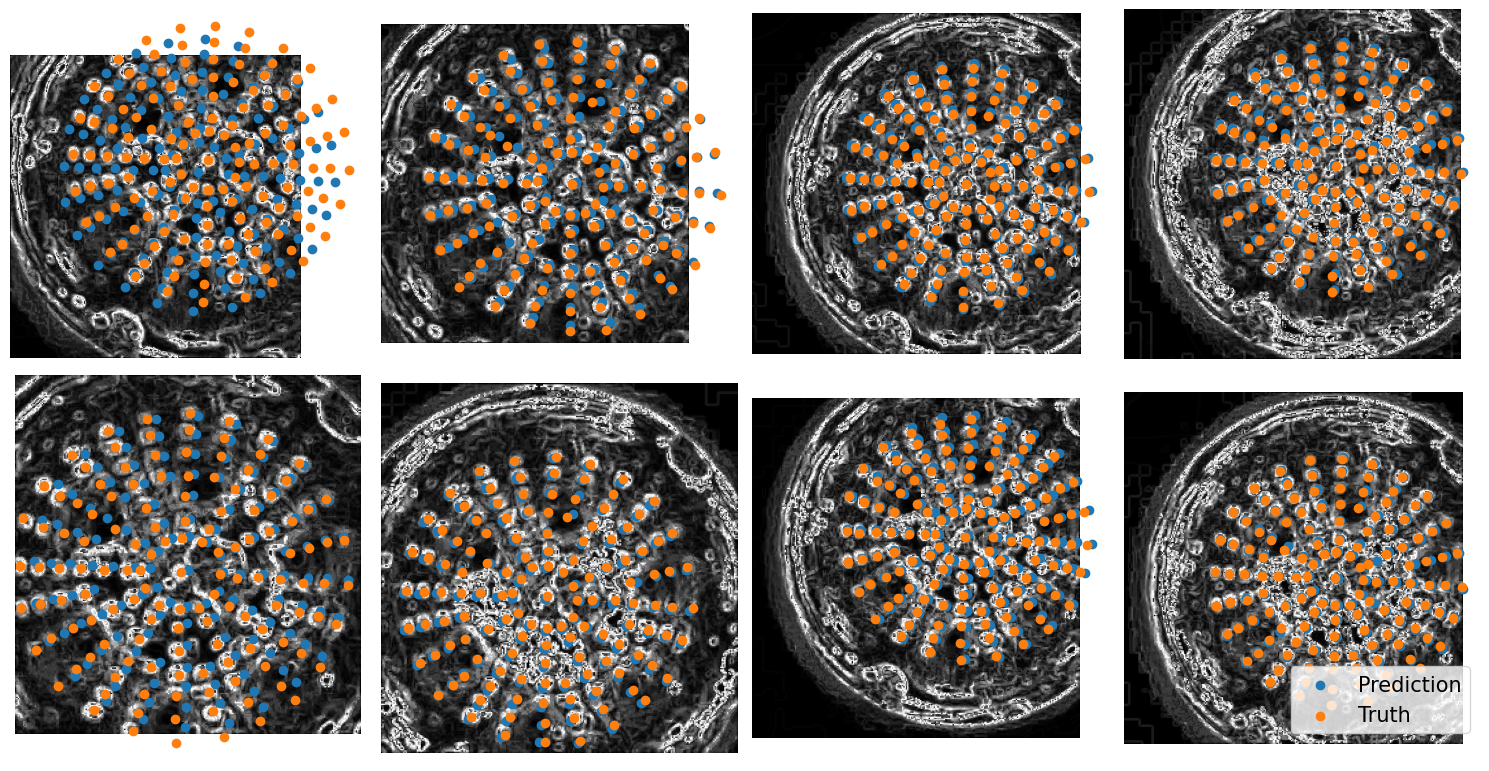

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(15,8))
axes = axes.flatten()

for i in range(8):
    preds=coords.reshape((len(coords),133,2))

    truth=y_test.reshape((len(y_test),133,2))

    axes[i].imshow(X_test[i].reshape((270,260,)).astype(np.uint8),cmap="gray")
    axes[i].scatter(preds[i,:,0],preds[i,:,1],label="Prediction")
    axes[i].scatter(truth[i,:,0],truth[i,:,1],label="Truth")
    axes[i].axis("off")

plt.legend(loc="lower right",fontsize=15)
plt.tight_layout()
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/regressionPointPred_.pdf")
plt.show()